In [2]:
# ================================================================
# SETUP AND INSTALLATION
# ================================================================

# Install required packages
!pip install spacy pandas networkx matplotlib tqdm
!python -m spacy download en_core_web_sm

# Check if GPU is available and set up acceleration
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU device:", torch.cuda.get_device_name(0))
    print("GPU memory:", torch.cuda.get_device_properties(0).total_memory / 1024**3, "GB")

# Import required libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Setup completed successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 123.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
CUDA available: True
GPU device: Tesla T4
GPU memory: 14.74127197265625 GB
Setup completed successfully!


In [3]:
# ================================================================
# LOAD THE TIMEML ANNOTATOR
# ================================================================

# Upload temporal_reasoning.py file or paste the code
# For Colab, you can either:
# 1. Upload the file using files.upload()
# 2. Save the code directly in a cell
# 3. Mount Google Drive and load from there

from google.colab import files
import io

# Option 1: Upload the temporal_reasoning.py file
print("Please upload your temporal_reasoning.py file:")
uploaded = files.upload()

# Save the uploaded file
for filename in uploaded.keys():
    with open(filename, 'wb') as f:
        f.write(uploaded[filename])
    print(f"Saved {filename}")

# Import the TimeMLAnnotator class
from temporal_reasoning import TimeMLAnnotator

print("TimeMLAnnotator imported successfully!")


Please upload your temporal_reasoning.py file:


TimeMLAnnotator imported successfully!


In [5]:
# ================================================================
# LOAD AND EXPLORE THE DATA
# ================================================================

# Upload the CSV file
print("Please upload your train_ablation.csv file:")
uploaded_csv = files.upload()

# Load the dataframe
csv_filename = list(uploaded_csv.keys())[0]
df = pd.read_csv(csv_filename)

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Check if 'generation' column exists
if 'generation' not in df.columns:
    print("WARNING: 'generation' column not found!")
    print("Available columns:", list(df.columns))
else:
    print(f"'generation' column found with {df['generation'].notna().sum()} non-null values")

# Display basic info about the dataset
print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)
print(df.info())
print("\nFirst few rows:")
print(df.head())

# Check the generation column specifically
if 'generation' in df.columns:
    print(f"\nGeneration column statistics:")
    print(f"Non-null values: {df['generation'].notna().sum()}")
    print(f"Null values: {df['generation'].isna().sum()}")
    print(f"Average text length: {df['generation'].str.len().mean():.1f} characters")
    print(f"Max text length: {df['generation'].str.len().max()} characters")
    print(f"Min text length: {df['generation'].str.len().min()} characters")

    # Show sample texts
    print(f"\nSample texts from 'generation' column:")
    for i, text in enumerate(df['generation'].dropna().head(3)):
        print(f"\nSample {i+1}:")
        print(f"Length: {len(text)} characters")
        print(f"Text: {text[:200]}{'...' if len(text) > 200 else ''}")


Please upload your train_ablation.csv file:


Saving train_ablation.csv to train_ablation (1).csv
Dataset loaded successfully!
Shape: (16000, 18)
Columns: ['gpt2_perplexity', 'type_token_ratio', 'repeated_3gram_ratio', 'unique_2grams', 'unique_3grams', 'sentence_length_std', 'sentence_length_entropy', 'pos_transition_entropy', 'punctuation_ratio', 'avg_word_length', 'flesch_reading_ease', 'pos_ratio_X', 'binary_label', 'binary_label_code', 'generation', 'id', 'adv_source_id', 'source_id']
'generation' column found with 16000 non-null values

DATASET OVERVIEW
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gpt2_perplexity          16000 non-null  float64
 1   type_token_ratio         16000 non-null  float64
 2   repeated_3gram_ratio     16000 non-null  float64
 3   unique_2grams            16000 non-null  float64
 4   unique_3grams            16000 non-null  fl

In [6]:
# ================================================================
# CONFIGURE ANNOTATION PARAMETERS
# ================================================================

# Configuration for annotation
BATCH_SIZE = 100  # Process in batches for memory efficiency
SAMPLE_SIZE = None  # Set to None to process all data, or set a number to sample

print("\n" + "="*50)
print("ANNOTATION CONFIGURATION")
print("="*50)
print(f"Batch size: {BATCH_SIZE}")
print(f"Sample size: {SAMPLE_SIZE if SAMPLE_SIZE else 'All data'}")

# Option to sample data for faster processing (useful for large datasets)
if SAMPLE_SIZE and len(df) > SAMPLE_SIZE:
    df_sample = df.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)
    print(f"Sampling {SAMPLE_SIZE} rows from {len(df)} total rows")
else:
    df_sample = df.copy()
    print(f"Processing all {len(df)} rows")

# ================================================================
# INITIALIZE ANNOTATOR AND PERFORM ANNOTATION
# ================================================================

# Initialize the TimeML annotator
print("\n" + "="*50)
print("INITIALIZING TIMEML ANNOTATOR")
print("="*50)

try:
    annotator = TimeMLAnnotator()
    print("TimeML Annotator initialized successfully!")
except Exception as e:
    print(f"Error initializing annotator: {e}")
    raise

# Function to process dataframe in batches with progress tracking
def process_dataframe_in_batches(df, annotator, text_column='generation', batch_size=100):
    """Process dataframe in batches to manage memory efficiently."""
    total_rows = len(df)
    all_annotations = []

    print(f"Processing {total_rows} rows in batches of {batch_size}")

    for start_idx in tqdm(range(0, total_rows, batch_size), desc="Processing batches"):
        end_idx = min(start_idx + batch_size, total_rows)
        batch_df = df.iloc[start_idx:end_idx].copy()

        # Process the batch
        batch_annotations = []
        for idx, row in batch_df.iterrows():
            try:
                text = str(row[text_column]) if pd.notna(row[text_column]) else ""
                if text.strip():  # Only process non-empty texts
                    annotation = annotator.annotate_text(text)
                    annotation['original_index'] = idx
                else:
                    # Create empty annotation for empty texts
                    annotation = {
                        'text': text,
                        'timexes': [],
                        'events': [],
                        'tlinks': [],
                        'original_index': idx
                    }
                batch_annotations.append(annotation)
            except Exception as e:
                print(f"Error processing row {idx}: {e}")
                # Create empty annotation for failed processing
                annotation = {
                    'text': str(row[text_column]) if pd.notna(row[text_column]) else "",
                    'timexes': [],
                    'events': [],
                    'tlinks': [],
                    'original_index': idx,
                    'error': str(e)
                }
                batch_annotations.append(annotation)

        all_annotations.extend(batch_annotations)

    return all_annotations

# Perform the annotation
print("\n" + "="*50)
print("PERFORMING TIMEML ANNOTATION")
print("="*50)

try:
    # Process the dataframe
    annotations = process_dataframe_in_batches(
        df_sample,
        annotator,
        text_column='generation',
        batch_size=BATCH_SIZE
    )

    # Add annotations to dataframe
    df_annotated = df_sample.copy()
    df_annotated['timeml_annotation'] = annotations

    print(f"Annotation completed successfully!")
    print(f"Processed {len(annotations)} texts")

except Exception as e:
    print(f"Error during annotation: {e}")
    raise

# ================================================================
# ANALYZE ANNOTATION RESULTS
# ================================================================

print("\n" + "="*50)
print("ANNOTATION ANALYSIS")
print("="*50)

# Get comprehensive statistics
stats = annotator.get_annotation_statistics(annotations)

print("Overall Statistics:")
print(f"  Total texts processed: {stats['total_texts']}")
print(f"  Total events found: {stats['total_events']}")
print(f"  Total temporal expressions found: {stats['total_timexes']}")
print(f"  Total temporal links found: {stats['total_tlinks']}")
print(f"  Average events per text: {stats['avg_events_per_text']:.2f}")
print(f"  Average temporal expressions per text: {stats['avg_timexes_per_text']:.2f}")
print(f"  Average temporal links per text: {stats['avg_tlinks_per_text']:.2f}")

print("\nEvent Classes Distribution:")
for event_class, count in sorted(stats['event_classes'].items(), key=lambda x: x[1], reverse=True):
    print(f"  {event_class}: {count}")

print("\nTemporal Expression Types:")
for timex_type, count in sorted(stats['timex_types'].items(), key=lambda x: x[1], reverse=True):
    print(f"  {timex_type}: {count}")

print("\nTemporal Link Types:")
for tlink_type, count in sorted(stats['tlink_types'].items(), key=lambda x: x[1], reverse=True):
    print(f"  {tlink_type}: {count}")


ANNOTATION CONFIGURATION
Batch size: 100
Sample size: All data
Processing all 16000 rows

INITIALIZING TIMEML ANNOTATOR
TimeML Annotator initialized successfully!

PERFORMING TIMEML ANNOTATION
Processing 16000 rows in batches of 100


Processing batches: 100%|██████████| 160/160 [28:30<00:00, 10.69s/it]


Annotation completed successfully!
Processed 16000 texts

ANNOTATION ANALYSIS
Overall Statistics:
  Total texts processed: 16000
  Total events found: 960121
  Total temporal expressions found: 118079
  Total temporal links found: 1564384
  Average events per text: 60.01
  Average temporal expressions per text: 7.38
  Average temporal links per text: 97.77

Event Classes Distribution:
  ACTION: 381926
  OCCURRENCE: 258043
  STATE: 212189
  MODAL: 34303
  REPORTING: 19748
  COGNITION: 14666
  PERCEPTION: 11852
  ASPECTUAL: 9333
  COMMUNICATION: 7949
  INTENTION: 6417
  EMOTION: 3695

Temporal Expression Types:
  DATE: 107744
  DURATION: 7559
  TIME: 2776

Temporal Link Types:
  BEFORE: 914818
  DURING: 290357
  IS_INCLUDED: 278030
  AFTER: 69255
  SIMULTANEOUS: 11924



CREATING VISUALIZATIONS


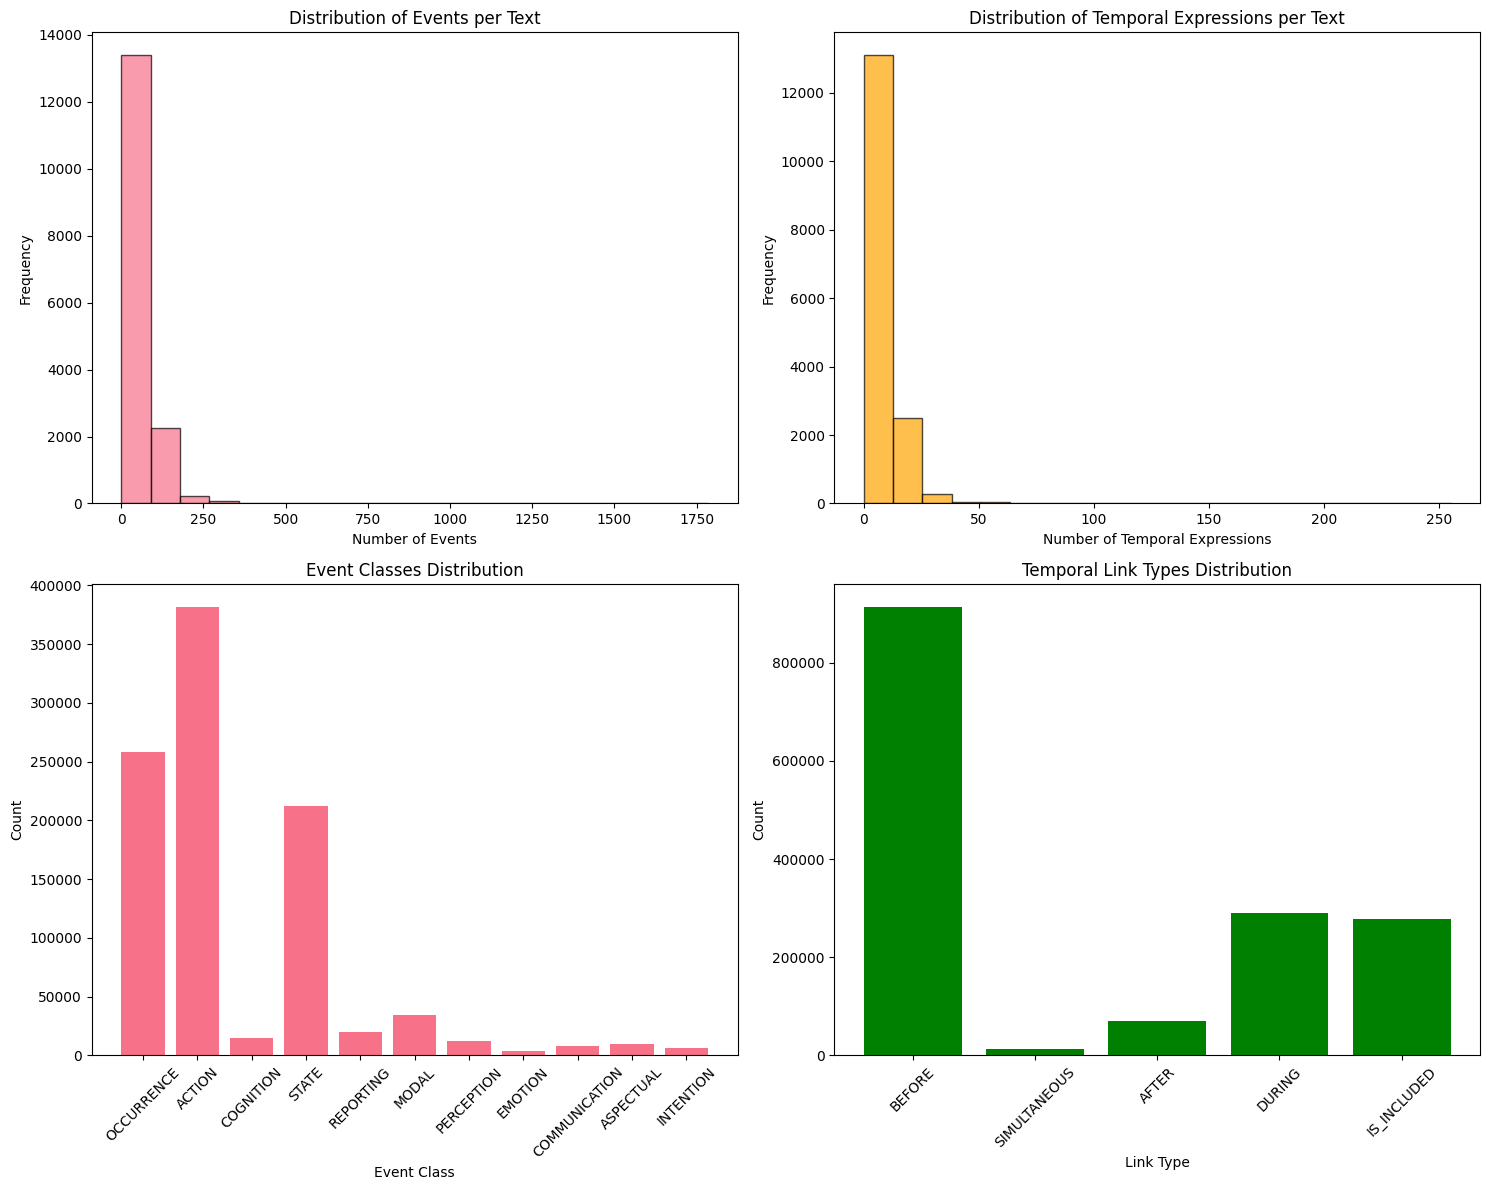


CREATING TEMPORAL GRAPH

DETAILED SAMPLE ANALYSIS
Showing detailed analysis for 3 sample texts:

SAMPLE 1
Text: This started before I went on vacation, but out of know where or it came on gradually burning and discomfort pain inside my penis all the way up to the groin. The thing is when I pee I don’t feel any ...

Events found (57):
  - 'started' (Class: OCCURRENCE, Tense: PAST)
  - 'went' (Class: ACTION, Tense: PAST)
  - 'know' (Class: COGNITION, Tense: NONE)
  - 'came' (Class: OCCURRENCE, Tense: PAST)
  - 'burning' (Class: ACTION, Tense: PRESENT)

Temporal Expressions found (5):
  - 'now' (Type: DATE, Value: 2025-07-17T20:28:19.217144)
  - 'for ' (Type: DATE, Value: for)
  - 'for Monday' (Type: DATE, Value: for monday)
  - 'since this ' (Type: DATE, Value: since this)
  - '6 days' (Type: DURATION, Value: 6 days)

Temporal Links found (96):
  - Event e1 BEFORE Event e2
  - Event e2 BEFORE Event e3
  - Event e3 BEFORE Event e4
  - Event e4 BEFORE Event e5
  - Event e5 BEFORE Event e6

NameError: name 'temporal_graph' is not defined

In [7]:
# ================================================================
# VISUALIZE RESULTS
# ================================================================

print("\n" + "="*50)
print("CREATING VISUALIZATIONS")
print("="*50)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Distribution of events per text
event_counts = [len(ann['events']) for ann in annotations]
axes[0, 0].hist(event_counts, bins=20, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Events per Text')
axes[0, 0].set_xlabel('Number of Events')
axes[0, 0].set_ylabel('Frequency')

# 2. Distribution of temporal expressions per text
timex_counts = [len(ann['timexes']) for ann in annotations]
axes[0, 1].hist(timex_counts, bins=20, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_title('Distribution of Temporal Expressions per Text')
axes[0, 1].set_xlabel('Number of Temporal Expressions')
axes[0, 1].set_ylabel('Frequency')

# 3. Event classes distribution
event_classes = list(stats['event_classes'].keys())
event_counts_by_class = list(stats['event_classes'].values())
axes[1, 0].bar(event_classes, event_counts_by_class)
axes[1, 0].set_title('Event Classes Distribution')
axes[1, 0].set_xlabel('Event Class')
axes[1, 0].set_ylabel('Count')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Temporal link types distribution
tlink_types = list(stats['tlink_types'].keys())
tlink_counts = list(stats['tlink_types'].values())
axes[1, 1].bar(tlink_types, tlink_counts, color='green')
axes[1, 1].set_title('Temporal Link Types Distribution')
axes[1, 1].set_xlabel('Link Type')
axes[1, 1].set_ylabel('Count')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# ================================================================
# CREATE AND VISUALIZE TEMPORAL GRAPH
# ================================================================

print("\n" + "="*50)
print("CREATING TEMPORAL GRAPH")
print("="*50)

# Create temporal graph from all annotations
#temporal_graph = annotator.create_temporal_graph(annotations)

#print(f"Temporal Graph Statistics:")
#print(f"  Nodes: {temporal_graph.number_of_nodes()}")
#print(f"  Edges: {temporal_graph.number_of_edges()}")

# Visualize a subset of the graph (for better readability)
#if temporal_graph.number_of_nodes() > 0:
    #print("Visualizing temporal graph...")
    #annotator.visualize_temporal_graph(temporal_graph, figsize=(16, 10))
#else:
    #print("No temporal relationships found to visualize.")

# ================================================================
# SAMPLE DETAILED ANALYSIS
# ================================================================

print("\n" + "="*50)
print("DETAILED SAMPLE ANALYSIS")
print("="*50)

# Show detailed analysis of a few sample texts
n_samples = min(3, len(annotations))
print(f"Showing detailed analysis for {n_samples} sample texts:")

for i in range(n_samples):
    annotation = annotations[i]
    print(f"\n{'='*60}")
    print(f"SAMPLE {i+1}")
    print(f"{'='*60}")
    print(f"Text: {annotation['text'][:200]}{'...' if len(annotation['text']) > 200 else ''}")
    print(f"\nEvents found ({len(annotation['events'])}):")
    for event in annotation['events'][:5]:  # Show first 5 events
        print(f"  - '{event['text']}' (Class: {event['class']}, Tense: {event['tense']})")

    print(f"\nTemporal Expressions found ({len(annotation['timexes'])}):")
    for timex in annotation['timexes'][:5]:  # Show first 5 timexes
        print(f"  - '{timex['text']}' (Type: {timex['type']}, Value: {timex['value']})")

    print(f"\nTemporal Links found ({len(annotation['tlinks'])}):")
    for tlink in annotation['tlinks'][:5]:  # Show first 5 tlinks
        if 'relatedToEvent' in tlink:
            print(f"  - Event {tlink['eventInstanceID']} {tlink['relType']} Event {tlink['relatedToEvent']}")
        else:
            print(f"  - Event {tlink['eventInstanceID']} {tlink['relType']} Time {tlink['relatedToTime']}")

# ================================================================
# EXPORT RESULTS
# ================================================================

print("\n" + "="*50)
print("EXPORTING RESULTS")
print("="*50)

# Save annotated dataframe
output_filename = 'annotated_train_ablation.csv'
df_annotated.to_csv(output_filename, index=False)
print(f"Annotated dataframe saved as: {output_filename}")

# Export sample TimeML XML
if annotations:
    sample_xml = annotator.export_to_timeml_xml(annotations[0])
    with open('sample_timeml_output.xml', 'w', encoding='utf-8') as f:
        f.write(sample_xml)
    print("Sample TimeML XML saved as: sample_timeml_output.xml")

# Create summary report
summary_report = f"""
TimeML Temporal Annotation Summary Report
=========================================

Dataset: {csv_filename}
Processing Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

Dataset Statistics:
- Total texts processed: {len(annotations)}
- Original dataset size: {len(df)}

Annotation Results:
- Total events: {stats['total_events']}
- Total temporal expressions: {stats['total_timexes']}
- Total temporal links: {stats['total_tlinks']}
- Average events per text: {stats['avg_events_per_text']:.2f}
- Average temporal expressions per text: {stats['avg_timexes_per_text']:.2f}
- Average temporal links per text: {stats['avg_tlinks_per_text']:.2f}

Event Classes:
{chr(10).join([f'- {k}: {v}' for k, v in sorted(stats['event_classes'].items(), key=lambda x: x[1], reverse=True)])}

Temporal Expression Types:
{chr(10).join([f'- {k}: {v}' for k, v in sorted(stats['timex_types'].items(), key=lambda x: x[1], reverse=True)])}

Temporal Link Types:
{chr(10).join([f'- {k}: {v}' for k, v in sorted(stats['tlink_types'].items(), key=lambda x: x[1], reverse=True)])}
"""

with open('timeml_annotation_report.txt', 'w', encoding='utf-8') as f:
    f.write(summary_report)

print("Summary report saved as: timeml_annotation_report.txt")

# Download files to local machine
print("\nDownloading files...")
files.download(output_filename)
files.download('sample_timeml_output.xml')
files.download('timeml_annotation_report.txt')

print("\n" + "="*50)
print("ANNOTATION PROCESS COMPLETED SUCCESSFULLY!")
print("="*50)
print("Files generated:")
print(f"1. {output_filename} - Annotated dataset")
print("2. sample_timeml_output.xml - Sample TimeML XML output")
print("3. timeml_annotation_report.txt - Summary report")
print("\nThe temporal graph visualization has been displayed above.")
print("All files have been downloaded to your local machine.")


In [8]:
def analyze_temporal_complexity(annotations):
    """Analyze the temporal complexity of texts."""
    complexity_scores = []

    for ann in annotations:
        # Calculate complexity based on various factors
        num_events = len(ann['events'])
        num_timexes = len(ann['timexes'])
        num_tlinks = len(ann['tlinks'])
        text_length = len(ann['text'])

        # Simple complexity score
        complexity = (num_events + num_timexes * 1.5 + num_tlinks * 2) / max(text_length / 100, 1)
        complexity_scores.append(complexity)

    return complexity_scores

def find_most_temporally_complex_texts(df_annotated, top_n=5):
    """Find the most temporally complex texts."""
    complexity_scores = analyze_temporal_complexity(df_annotated['timeml_annotation'])
    df_with_complexity = df_annotated.copy()
    df_with_complexity['temporal_complexity'] = complexity_scores

    most_complex = df_with_complexity.nlargest(top_n, 'temporal_complexity')
    return most_complex

# Example usage of additional analysis
print("\n" + "="*50)
print("TEMPORAL COMPLEXITY ANALYSIS")
print("="*50)

complexity_scores = analyze_temporal_complexity(annotations)
print(f"Average temporal complexity score: {np.mean(complexity_scores):.2f}")
print(f"Max temporal complexity score: {np.max(complexity_scores):.2f}")
print(f"Min temporal complexity score: {np.min(complexity_scores):.2f}")

# Find most complex texts
most_complex = find_most_temporally_complex_texts(df_annotated, top_n=3)
print(f"\nTop 3 most temporally complex texts:")
for i, (idx, row) in enumerate(most_complex.iterrows()):
    print(f"\n{i+1}. Complexity Score: {row['temporal_complexity']:.2f}")
    print(f"   Text: {row['generation'][:150]}{'...' if len(row['generation']) > 150 else ''}")
    ann = row['timeml_annotation']
    print(f"   Events: {len(ann['events'])}, Timexes: {len(ann['timexes'])}, Links: {len(ann['tlinks'])}")

print("\n" + "="*60)
print("ANALYSIS COMPLETE - ALL RESULTS SAVED AND DOWNLOADED")
print("="*60)


TEMPORAL COMPLEXITY ANALYSIS
Average temporal complexity score: 16.98
Max temporal complexity score: 54.46
Min temporal complexity score: 0.00

Top 3 most temporally complex texts:

1. Complexity Score: 54.46
   Text: I am lost, I am lost, I am lost, I am lost, I am lost, I am lost, I am lost, I am lost, I am lost, I am lost, I am lost, I am lost, I am lost, I am lo...
   Events: 245, Timexes: 0, Links: 244

2. Complexity Score: 50.28
   Text: I'm a big fan of the song "I'm Not in Love" by The Killers. I've been listening to it for years and it's one of my favorite songs. I've been thinking ...
   Events: 180, Timexes: 26, Links: 383

3. Complexity Score: 46.31
   Text: My friend the poet, I have written this verse for you. I have written this verse for you. I have written this verse for you. I have written this verse...
   Events: 111, Timexes: 37, Links: 221

ANALYSIS COMPLETE - ALL RESULTS SAVED AND DOWNLOADED


COMPARATIVE TEMPORAL ANALYSIS: HUMAN vs AI
Extracting comparative metrics...
Human texts: 8000
AI texts: 8000


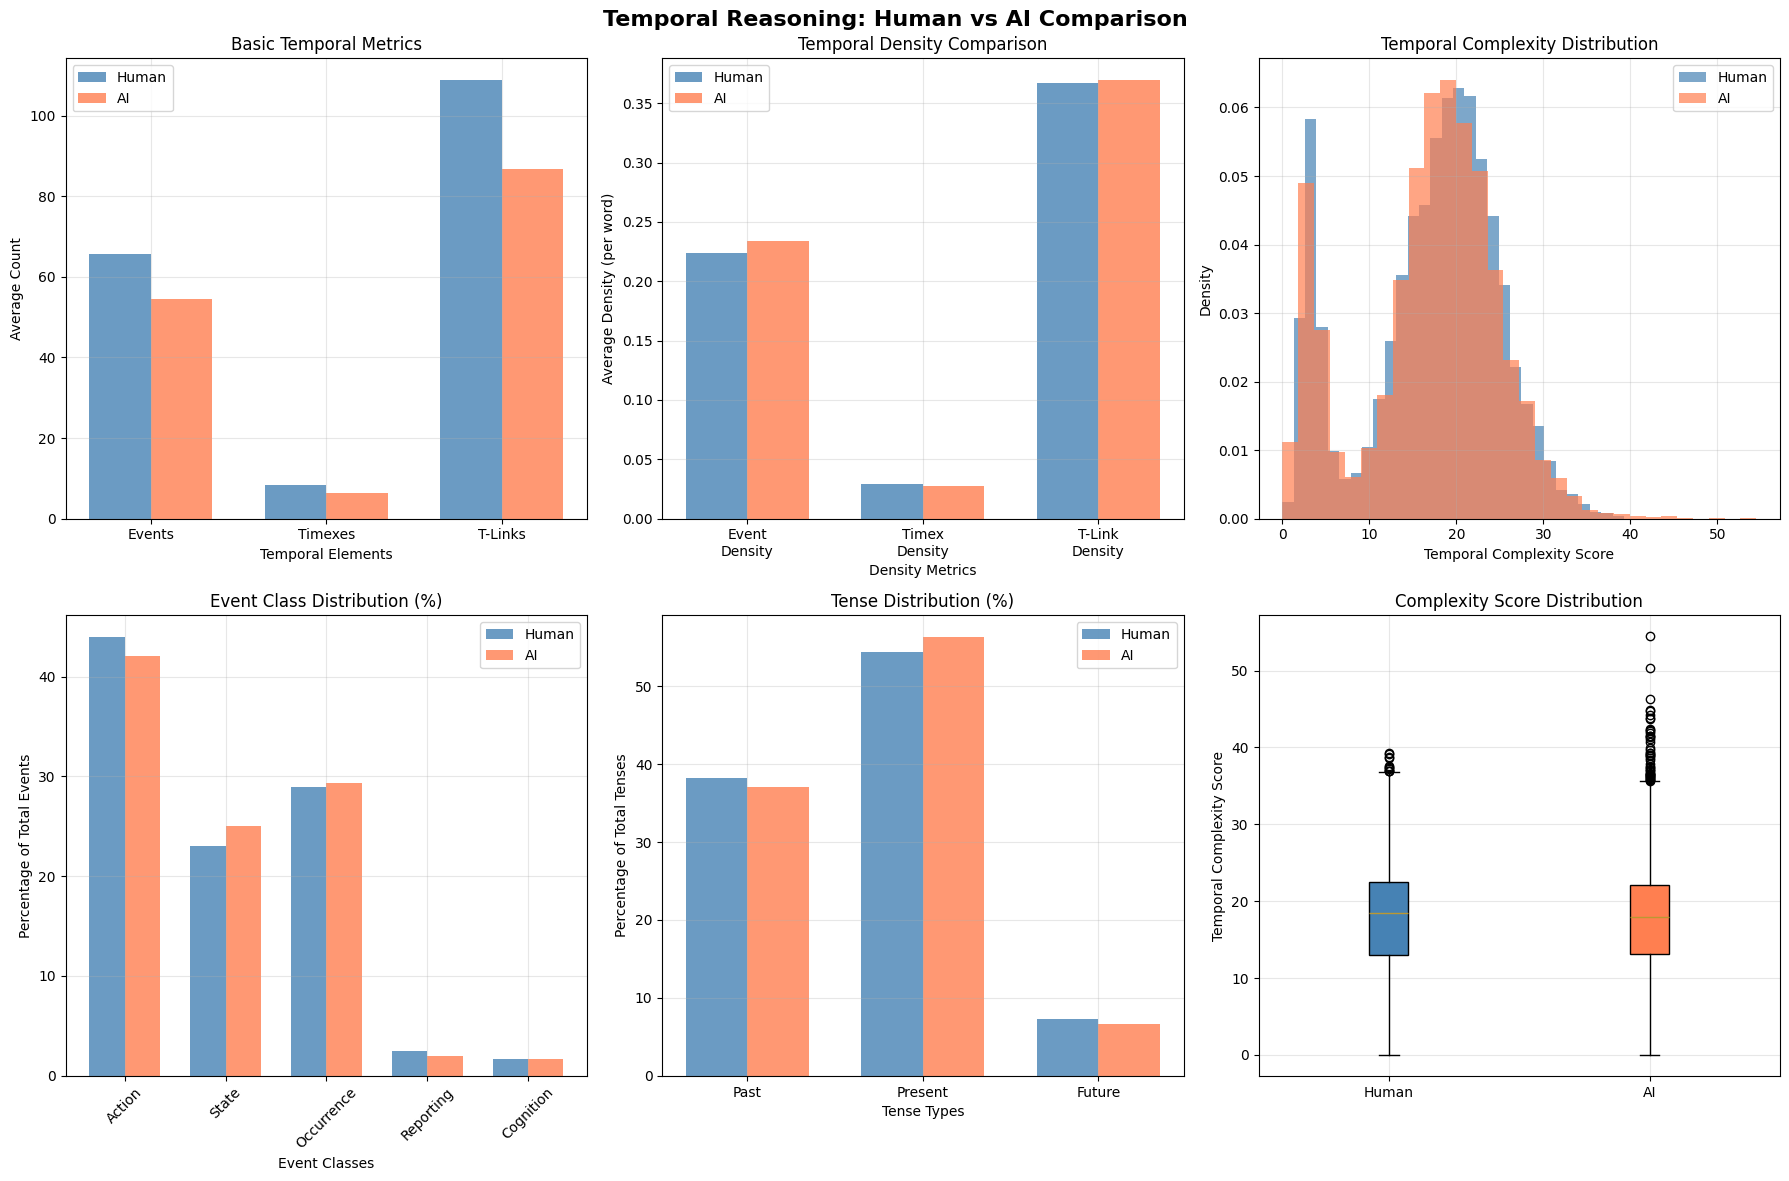


STATISTICAL ANALYSIS

SIGNIFICANT DIFFERENCES (p < 0.05):
--------------------------------------------------

NUM EVENTS:
  Human: 65.629 ± 67.791
  AI: 54.386 ± 33.537
  Difference: 11.242
  p-value: 0.0000
  Effect size (Cohen's d): 0.210
  Effect size: small

NUM TIMEXES:
  Human: 8.312 ± 9.501
  AI: 6.448 ± 6.778
  Difference: 1.864
  p-value: 0.0000
  Effect size (Cohen's d): 0.226
  Effect size: small

NUM TLINKS:
  Human: 108.751 ± 120.554
  AI: 86.797 ± 57.872
  Difference: 21.954
  p-value: 0.0000
  Effect size (Cohen's d): 0.232
  Effect size: small

EVENT DENSITY:
  Human: 0.224 ± 0.079
  AI: 0.234 ± 0.088
  Difference: -0.010
  p-value: 0.0000
  Effect size (Cohen's d): -0.116
  Effect size: negligible

TIMEX DENSITY:
  Human: 0.029 ± 0.022
  AI: 0.027 ± 0.032
  Difference: 0.002
  p-value: 0.0000
  Effect size (Cohen's d): 0.072
  Effect size: negligible

INTERACTIVE VISUALIZATIONS



KEY INSIGHTS

1. TEMPORAL COMPLEXITY:
   → Human texts are 0.23 points more complex on average

2. EVENT USAGE:
   → Human texts use 11.2 more events per text on average

3. TEMPORAL EXPRESSIONS:
   → Human texts use 1.9 more temporal expressions per text

4. TENSE PREFERENCES:
   → Human texts use past tense 38.2% of the time
   → AI texts use past tense 37.1% of the time

5. EVENT TYPES:
   → Human texts use action events 45.8% of the time
   → AI texts use action events 43.6% of the time

6. VARIABILITY:
   → Human complexity std: 7.86
   → AI complexity std: 7.94
   → AI texts show more variability in temporal complexity

Comparative analysis saved to 'temporal_comparative_analysis.csv'

COMPARATIVE ANALYSIS COMPLETE


In [14]:
# ================================================================
# COMPARATIVE ANALYSIS: HUMAN vs AI TEMPORAL REASONING
# ================================================================

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats as scipy_stats # Renamed import to avoid conflict
import warnings
warnings.filterwarnings('ignore')

print("=" * 70)
print("COMPARATIVE TEMPORAL ANALYSIS: HUMAN vs AI")
print("=" * 70)

# Prepare comparative data
def extract_comparative_metrics(df_annotated):
    """Extract metrics for comparative analysis."""
    results = []

    for idx, row in df_annotated.iterrows():
        annotation = row['timeml_annotation']

        # Basic counts
        num_events = len(annotation['events'])
        num_timexes = len(annotation['timexes'])
        num_tlinks = len(annotation['tlinks'])
        text_length = len(annotation['text'])
        word_count = len(annotation['text'].split())

        # Event class distribution
        event_classes = {'ACTION': 0, 'STATE': 0, 'OCCURRENCE': 0, 'REPORTING': 0, 'COGNITION': 0}
        for event in annotation['events']:
            event_classes[event['class']] = event_classes.get(event['class'], 0) + 1

        # Tense distribution
        tense_dist = {'PAST': 0, 'PRESENT': 0, 'FUTURE': 0, 'NONE': 0}
        for event in annotation['events']:
            tense_dist[event['tense']] = tense_dist.get(event['tense'], 0) + 1

        # Temporal expression types
        timex_types = {'DATE': 0, 'TIME': 0, 'DURATION': 0}
        for timex in annotation['timexes']:
            timex_types[timex['type']] = timex_types.get(timex['type'], 0) + 1

        # Densities (normalized by word count)
        event_density = num_events / max(word_count, 1)
        timex_density = num_timexes / max(word_count, 1)
        tlink_density = num_tlinks / max(word_count, 1)

        # Temporal complexity score
        complexity = (num_events + num_timexes * 1.5 + num_tlinks * 2) / max(text_length / 100, 1)

        results.append({
            'label': row['binary_label'],
            'num_events': num_events,
            'num_timexes': num_timexes,
            'num_tlinks': num_tlinks,
            'text_length': text_length,
            'word_count': word_count,
            'event_density': event_density,
            'timex_density': timex_density,
            'tlink_density': tlink_density,
            'temporal_complexity': complexity,
            'action_events': event_classes['ACTION'],
            'state_events': event_classes['STATE'],
            'occurrence_events': event_classes['OCCURRENCE'],
            'reporting_events': event_classes['REPORTING'],
            'cognition_events': event_classes['COGNITION'],
            'past_tense': tense_dist['PAST'],
            'present_tense': tense_dist['PRESENT'],
            'future_tense': tense_dist['FUTURE'],
            'date_timexes': timex_types['DATE'],
            'time_timexes': timex_types['TIME'],
            'duration_timexes': timex_types['DURATION']
        })

    return pd.DataFrame(results)

# Extract metrics
print("Extracting comparative metrics...")
comparative_df = extract_comparative_metrics(df_annotated)

# Separate human and AI data
human_data = comparative_df[comparative_df['label'] == 'human']
ai_data = comparative_df[comparative_df['label'] == 'artificial']

print(f"Human texts: {len(human_data)}")
print(f"AI texts: {len(ai_data)}")

# ================================================================
# VISUALIZATION 1: MAIN METRICS COMPARISON (Matplotlib)
# ================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Temporal Reasoning: Human vs AI Comparison', fontsize=16, fontweight='bold')

# 1. Basic Counts
metrics = ['num_events', 'num_timexes', 'num_tlinks']
human_means = [human_data[metric].mean() for metric in metrics]
ai_means = [ai_data[metric].mean() for metric in metrics]

x = np.arange(len(metrics))
width = 0.35

axes[0,0].bar(x - width/2, human_means, width, label='Human', alpha=0.8, color='steelblue')
axes[0,0].bar(x + width/2, ai_means, width, label='AI', alpha=0.8, color='coral')
axes[0,0].set_xlabel('Temporal Elements')
axes[0,0].set_ylabel('Average Count')
axes[0,0].set_title('Basic Temporal Metrics')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(['Events', 'Timexes', 'T-Links'])
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Density Comparison
density_metrics = ['event_density', 'timex_density', 'tlink_density']
human_density = [human_data[metric].mean() for metric in density_metrics]
ai_density = [ai_data[metric].mean() for metric in density_metrics]

axes[0,1].bar(x - width/2, human_density, width, label='Human', alpha=0.8, color='steelblue')
axes[0,1].bar(x + width/2, ai_density, width, label='AI', alpha=0.8, color='coral')
axes[0,1].set_xlabel('Density Metrics')
axes[0,1].set_ylabel('Average Density (per word)')
axes[0,1].set_title('Temporal Density Comparison')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(['Event\nDensity', 'Timex\nDensity', 'T-Link\nDensity'])
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Complexity Distribution
axes[0,2].hist(human_data['temporal_complexity'], bins=30, alpha=0.7,
               label='Human', color='steelblue', density=True)
axes[0,2].hist(ai_data['temporal_complexity'], bins=30, alpha=0.7,
               label='AI', color='coral', density=True)
axes[0,2].set_xlabel('Temporal Complexity Score')
axes[0,2].set_ylabel('Density')
axes[0,2].set_title('Temporal Complexity Distribution')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# 4. Event Classes
event_classes = ['action_events', 'state_events', 'occurrence_events', 'reporting_events', 'cognition_events']
human_events = [human_data[cls].sum() for cls in event_classes]
ai_events = [ai_data[cls].sum() for cls in event_classes]

# Normalize by total events
human_total = sum(human_events)
ai_total = sum(ai_events)
human_events_norm = [x/human_total*100 if human_total > 0 else 0 for x in human_events]
ai_events_norm = [x/ai_total*100 if ai_total > 0 else 0 for x in ai_events]

x = np.arange(len(event_classes))
axes[1,0].bar(x - width/2, human_events_norm, width, label='Human', alpha=0.8, color='steelblue')
axes[1,0].bar(x + width/2, ai_events_norm, width, label='AI', alpha=0.8, color='coral')
axes[1,0].set_xlabel('Event Classes')
axes[1,0].set_ylabel('Percentage of Total Events')
axes[1,0].set_title('Event Class Distribution (%)')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(['Action', 'State', 'Occurrence', 'Reporting', 'Cognition'], rotation=45)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 5. Tense Distribution
tense_cols = ['past_tense', 'present_tense', 'future_tense']
human_tenses = [human_data[tense].sum() for tense in tense_cols]
ai_tenses = [ai_data[tense].sum() for tense in tense_cols]

# Normalize by total tenses
human_total_tense = sum(human_tenses)
ai_total_tense = sum(ai_tenses)
human_tenses_norm = [x/human_total_tense*100 if human_total_tense > 0 else 0 for x in human_tenses]
ai_tenses_norm = [x/ai_total_tense*100 if ai_total_tense > 0 else 0 for x in ai_tenses]

x = np.arange(len(tense_cols))
axes[1,1].bar(x - width/2, human_tenses_norm, width, label='Human', alpha=0.8, color='steelblue')
axes[1,1].bar(x + width/2, ai_tenses_norm, width, label='AI', alpha=0.8, color='coral')
axes[1,1].set_xlabel('Tense Types')
axes[1,1].set_ylabel('Percentage of Total Tenses')
axes[1,1].set_title('Tense Distribution (%)')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(['Past', 'Present', 'Future'])
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# 6. Box Plot Comparison
data_to_plot = [human_data['temporal_complexity'], ai_data['temporal_complexity']]
box_plot = axes[1,2].boxplot(data_to_plot, labels=['Human', 'AI'], patch_artist=True)
box_plot['boxes'][0].set_facecolor('steelblue')
box_plot['boxes'][1].set_facecolor('coral')
axes[1,2].set_ylabel('Temporal Complexity Score')
axes[1,2].set_title('Complexity Score Distribution')
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ================================================================
# STATISTICAL ANALYSIS
# ================================================================

print("\n" + "=" * 60)
print("STATISTICAL ANALYSIS")
print("=" * 60)

# Key metrics to analyze
metrics_to_analyze = [
    'num_events', 'num_timexes', 'num_tlinks', 'temporal_complexity',
    'event_density', 'timex_density', 'tlink_density'
]

print("\nSIGNIFICANT DIFFERENCES (p < 0.05):")
print("-" * 50)

for metric in metrics_to_analyze:
    human_values = human_data[metric].values
    ai_values = ai_data[metric].values

    # T-test
    t_stat, p_value = scipy_stats.ttest_ind(human_values, ai_values) # Use scipy_stats

    # Effect size (Cohen's d)
    pooled_std = np.sqrt(((len(human_values) - 1) * np.var(human_values) +
                         (len(ai_values) - 1) * np.var(ai_values)) /
                        (len(human_values) + len(ai_values) - 2))
    cohens_d = (np.mean(human_values) - np.mean(ai_values)) / pooled_std if pooled_std > 0 else 0

    if p_value < 0.05:
        print(f"\n{metric.upper().replace('_', ' ')}:")
        print(f"  Human: {np.mean(human_values):.3f} ± {np.std(human_values):.3f}")
        print(f"  AI: {np.mean(ai_values):.3f} ± {np.std(ai_values):.3f}")
        print(f"  Difference: {np.mean(human_values) - np.mean(ai_values):.3f}")
        print(f"  p-value: {p_value:.4f}")
        print(f"  Effect size (Cohen's d): {cohens_d:.3f}")

        # Interpret effect size
        if abs(cohens_d) < 0.2:
            effect_size = "negligible"
        elif abs(cohens_d) < 0.5:
            effect_size = "small"
        elif abs(cohens_d) < 0.8:
            effect_size = "medium"
        else:
            effect_size = "large"
        print(f"  Effect size: {effect_size}")

# ================================================================
# INTERACTIVE PLOTLY VISUALIZATIONS
# ================================================================

print("\n" + "=" * 60)
print("INTERACTIVE VISUALIZATIONS")
print("=" * 60)

# 1. Interactive Scatter Plot Matrix (excluding the pie chart)
# Changed the subplot specification for the pie chart position (row 2, col 2) to 'domain'
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Events vs Timexes', 'Complexity vs Text Length',
                   'Density Comparison', 'Tense Distribution'), # Updated title
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"type": "domain"}]] # Specified 'domain' type for the pie chart subplot
)

# Scatter plot: Events vs Timexes
fig.add_trace(go.Scatter(
    x=human_data['num_events'], y=human_data['num_timexes'],
    mode='markers', name='Human', marker=dict(color='steelblue', size=6, opacity=0.6)
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=ai_data['num_events'], y=ai_data['num_timexes'],
    mode='markers', name='AI', marker=dict(color='coral', size=6, opacity=0.6),
    showlegend=False
), row=1, col=1)


# Scatter plot: Complexity vs Text Length
fig.add_trace(go.Scatter(
    x=human_data['text_length'], y=human_data['temporal_complexity'],
    mode='markers', name='Human', marker=dict(color='steelblue', size=6, opacity=0.6),
    showlegend=False
), row=1, col=2)

fig.add_trace(go.Scatter(
    x=ai_data['text_length'], y=ai_data['temporal_complexity'],
    mode='markers', name='AI', marker=dict(color='coral', size=6, opacity=0.6),
    showlegend=False
), row=1, col=2)

# Bar chart: Density comparison
density_metrics = ['Event Density', 'Timex Density', 'T-Link Density']
human_density_vals = [human_data['event_density'].mean(),
                      human_data['timex_density'].mean(),
                      human_data['tlink_density'].mean()]
ai_density_vals = [ai_data['event_density'].mean(),
                   ai_data['timex_density'].mean(),
                   ai_data['tlink_density'].mean()]

fig.add_trace(go.Bar(
    x=density_metrics, y=human_density_vals,
    name='Human', marker_color='steelblue', showlegend=False
), row=2, col=1)

fig.add_trace(go.Bar(
    x=density_metrics, y=ai_density_vals,
    name='AI', marker_color='coral', showlegend=False
), row=2, col=1)

# Pie chart: Tense usage for Human and AI in the same subplot
# Corrected to use go.Pie instead of go.Box
fig.add_trace(go.Pie(
    labels=['Past', 'Present', 'Future'],
    values=[human_data['past_tense'].sum(),
            human_data['present_tense'].sum(),
            human_data['future_tense'].sum()],
    name="Human Tense",
    marker_colors=['lightblue', 'steelblue', 'darkblue'],
    domain={'x': [0, .48]} # Adjust domain to place side by side
), row=2, col=2) # Added row and col

fig.add_trace(go.Pie(
    labels=['Past', 'Present', 'Future'],
    values=[ai_data['past_tense'].sum(),
            ai_data['present_tense'].sum(),
            ai_data['future_tense'].sum()],
    name="AI Tense",
    marker_colors=['salmon', 'coral', 'darkred'],
    domain={'x': [.52, 1]} # Adjust domain to place side by side
), row=2, col=2) # Added row and col


fig.update_layout(
    title_text="Interactive Temporal Analysis Dashboard",
    showlegend=True,
    height=800
)

fig.show()

# 2. Box Plot Comparison for Multiple Metrics
fig2 = go.Figure()

for metric in ['num_events', 'num_timexes', 'num_tlinks', 'temporal_complexity']:
    fig2.add_trace(go.Box(
        y=human_data[metric],
        name=f'Human {metric.replace("_", " ").title()}',
        marker_color='steelblue'
    ))
    fig2.add_trace(go.Box(
        y=ai_data[metric],
        name=f'AI {metric.replace("_", " ").title()}',
        marker_color='coral'
    ))

fig2.update_layout(
    title="Distribution Comparison: Human vs AI Temporal Metrics",
    yaxis_title="Value",
    boxmode='group'
)

fig2.show()

# The separate pie chart figure is no longer needed as it's now part of the main subplot.
# # Create a separate figure for the Tense Distribution Pie Chart
# fig_pie = go.Figure()

# fig_pie.add_trace(go.Pie(
#     labels=['Past', 'Present', 'Future'],
#     values=[human_data['past_tense'].sum(),
#             human_data['present_tense'].sum(),
#             human_data['future_tense'].sum()],
#     name="Human Tense",
#     marker_colors=['lightblue', 'steelblue', 'darkblue'],
#     domain={'x': [0, .48]} # Adjust domain to place side by side
# ))

# fig_pie.add_trace(go.Pie(
#     labels=['Past', 'Present', 'Future'],
#     values=[ai_data['past_tense'].sum(),
#             ai_data['present_tense'].sum(),
#             ai_data['future_tense'].sum()],
#     name="AI Tense",
#     marker_colors=['salmon', 'coral', 'darkred'],
#     domain={'x': [.52, 1]} # Adjust domain to place side by side
# ))

# fig_pie.update_layout(
#     title_text="Tense Distribution: Human vs AI",
#     showlegend=True
# )

# fig_pie.show()


# ================================================================
# SUMMARY INSIGHTS
# ================================================================

print("\n" + "=" * 60)
print("KEY INSIGHTS")
print("=" * 60)

# Calculate key differences
complexity_diff = human_data['temporal_complexity'].mean() - ai_data['temporal_complexity'].mean()
event_diff = human_data['num_events'].mean() - ai_data['num_events'].mean()
timex_diff = human_data['num_timexes'].mean() - ai_data['num_timexes'].mean()

print(f"\n1. TEMPORAL COMPLEXITY:")
if complexity_diff > 0:
    print(f"   → Human texts are {complexity_diff:.2f} points more complex on average")
else:
    print(f"   → AI texts are {abs(complexity_diff):.2f} points more complex on average")

print(f"\n2. EVENT USAGE:")
if event_diff > 0:
    print(f"   → Human texts use {event_diff:.1f} more events per text on average")
else:
    print(f"   → AI texts use {abs(event_diff):.1f} more events per text on average")

print(f"\n3. TEMPORAL EXPRESSIONS:")
if timex_diff > 0:
    print(f"   → Human texts use {timex_diff:.1f} more temporal expressions per text")
else:
    print(f"   → AI texts use {abs(timex_diff):.1f} more temporal expressions per text")

# Tense preferences
human_total_tense = human_data['past_tense'].sum() + human_data['present_tense'].sum() + human_data['future_tense'].sum()
ai_total_tense = ai_data['past_tense'].sum() + ai_data['present_tense'].sum() + ai_data['future_tense'].sum()

human_past_pct = human_data['past_tense'].sum() / human_total_tense * 100 if human_total_tense > 0 else 0
ai_past_pct = ai_data['past_tense'].sum() / ai_total_tense * 100 if ai_total_tense > 0 else 0

print(f"\n4. TENSE PREFERENCES:")
print(f"   → Human texts use past tense {human_past_pct:.1f}% of the time")
print(f"   → AI texts use past tense {ai_past_pct:.1f}% of the time")

# Event class preferences
human_total_events_sum = human_data['action_events'].sum() + human_data['state_events'].sum() + human_data['occurrence_events'].sum()
ai_total_events_sum = ai_data['action_events'].sum() + ai_data['state_events'].sum() + ai_data['occurrence_events'].sum()

human_action_pct = human_data['action_events'].sum() / human_total_events_sum * 100 if human_total_events_sum > 0 else 0
ai_action_pct = ai_data['action_events'].sum() / ai_total_events_sum * 100 if ai_total_events_sum > 0 else 0

print(f"\n5. EVENT TYPES:")
print(f"   → Human texts use action events {human_action_pct:.1f}% of the time")
print(f"   → AI texts use action events {ai_action_pct:.1f}% of the time")

print(f"\n6. VARIABILITY:")
print(f"   → Human complexity std: {human_data['temporal_complexity'].std():.2f}")
print(f"   → AI complexity std: {ai_data['temporal_complexity'].std():.2f}")
if human_data['temporal_complexity'].std() > ai_data['temporal_complexity'].std():
    print("   → Human texts show more variability in temporal complexity")
else:
    print("   → AI texts show more variability in temporal complexity")


# Save comparative results
comparative_df.to_csv('temporal_comparative_analysis.csv', index=False)
print(f"\nComparative analysis saved to 'temporal_comparative_analysis.csv'")

print("\n" + "=" * 60)
print("COMPARATIVE ANALYSIS COMPLETE")
print("=" * 60)